In [3]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Configurar estilo de gráficos
sns.set(style="whitegrid")

# Cargar los datos
df = pd.read_excel('FuelConsumptionCo2.xlsx')

# Mostrar las primeras filas del dataframe
print(df.head())

   MODELYEAR   MAKE              MODEL VEHICLECLASS  ENGINESIZE  CYLINDERS  \
0       2022  Acura                ILX      Compact         2.4          4   
1       2022  Acura         MDX SH-AWD   SUV: Small         3.5          6   
2       2022  Acura         RDX SH-AWD   SUV: Small         2.0          4   
3       2022  Acura  RDX SH-AWD A-SPEC   SUV: Small         2.0          4   
4       2022  Acura         TLX SH-AWD      Compact         2.0          4   

  TRANSMISSION FUELTYPE  FUELCONSUMPTION_CITY  FUELCONSUMPTION_HWY  \
0          AM8        Z                   9.9                  7.0   
1         AS10        Z                  12.6                  9.4   
2         AS10        Z                  11.0                  8.6   
3         AS10        Z                  11.3                  9.1   
4         AS10        Z                  11.2                  8.0   

   FUELCONSUMPTION_COMB  FUELCONSUMPTION_COMB_MPG  CO2EMISSIONS  
0                   8.6                     

In [11]:
print(df.columns)


Index(['MODELYEAR', 'MAKE', 'MODEL', 'VEHICLECLASS', 'ENGINESIZE', 'CYLINDERS',
       'TRANSMISSION', 'FUELTYPE', 'FUELCONSUMPTION_CITY',
       'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB',
       'FUELCONSUMPTION_COMB_MPG', 'CO2EMISSIONS'],
      dtype='object')


In [13]:
# Eliminar columnas categóricas
df_numeric = df.select_dtypes(include=['int64', 'float64'])

# Verificar valores nulos
print("\nValores nulos por columna:")
print(df_numeric.isnull().sum())

# Eliminar filas con valores nulos si es necesario
df_clean = df_numeric.dropna()

# Verificar dimensiones después de la limpieza
print("\nDimensiones del dataframe limpio:", df_clean.shape)

# Separar variables predictoras y variable objetivo
X = df_clean.drop('CO2EMISSIONS', axis=1)
y = df_clean['CO2EMISSIONS']

# Dividir en conjuntos de entrenamiento y prueba (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos (importante para Ridge y Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Valores nulos por columna:
MODELYEAR                   0
ENGINESIZE                  0
CYLINDERS                   0
FUELCONSUMPTION_CITY        0
FUELCONSUMPTION_HWY         0
FUELCONSUMPTION_COMB        0
FUELCONSUMPTION_COMB_MPG    0
CO2EMISSIONS                0
dtype: int64

Dimensiones del dataframe limpio: (945, 8)


In [15]:
# Crear y entrenar el modelo de regresión lineal
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
y_pred_lr = lr.predict(X_test_scaled)

# Calcular métricas de evaluación
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)

# Mostrar resultados
print("\nResultados Regresión Lineal:")
print(f"R²: {r2_lr:.4f}")
print(f"MAE: {mae_lr:.4f}")
print(f"MSE: {mse_lr:.4f}")

# Predecir la primera observación del conjunto de prueba
first_pred_lr = lr.predict(X_test_scaled[0:1])
first_pred_predict = lr.predict(X_test_scaled)[0]

print("\nPredicción para la primera observación:")
print(f"Usando coeficientes manuales: {first_pred_lr[0]:.4f}")
print(f"Usando predict(): {first_pred_predict:.4f}")
print("¿Coinciden los resultados?", np.isclose(first_pred_lr[0], first_pred_predict))


Resultados Regresión Lineal:
R²: 0.9005
MAE: 7.3391
MSE: 368.8673

Predicción para la primera observación:
Usando coeficientes manuales: 242.9269
Usando predict(): 242.9269
¿Coinciden los resultados? True


In [18]:
# Definir el rango de valores alpha para probar
alphas = np.logspace(-4, 4, 100)

# Configurar búsqueda de grid para encontrar el mejor alpha
ridge = Ridge()
grid_ridge = GridSearchCV(estimator=ridge, param_grid={'alpha': alphas}, 
                         scoring='r2', cv=5, n_jobs=-1)
grid_ridge.fit(X_train_scaled, y_train)

# Mejor alpha encontrado
best_alpha_ridge = grid_ridge.best_params_['alpha']

# Entrenar modelo Ridge con el mejor alpha
ridge_opt = Ridge(alpha=best_alpha_ridge)
ridge_opt.fit(X_train_scaled, y_train)

# Predecir y evaluar
y_pred_ridge = ridge_opt.predict(X_test_scaled)

r2_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print("\nResultados Regresión Ridge:")
print(f"Mejor alpha: {best_alpha_ridge:.4f}")
print(f"R²: {r2_ridge:.4f}")
print(f"MAE: {mae_ridge:.4f}")
print(f"MSE: {mse_ridge:.4f}")


Resultados Regresión Ridge:
Mejor alpha: 14.8497
R²: 0.9032
MAE: 7.4919
MSE: 358.8894


In [20]:
# Configurar búsqueda de grid para Lasso
lasso = Lasso()
grid_lasso = GridSearchCV(estimator=lasso, param_grid={'alpha': alphas}, 
                         scoring='r2', cv=5, n_jobs=-1)
grid_lasso.fit(X_train_scaled, y_train)

# Mejor alpha encontrado
best_alpha_lasso = grid_lasso.best_params_['alpha']

# Entrenar modelo Lasso con el mejor alpha
lasso_opt = Lasso(alpha=best_alpha_lasso)
lasso_opt.fit(X_train_scaled, y_train)

# Predecir y evaluar
y_pred_lasso = lasso_opt.predict(X_test_scaled)

r2_lasso = r2_score(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

print("\nResultados Regresión Lasso:")
print(f"Mejor alpha: {best_alpha_lasso:.4f}")
print(f"R²: {r2_lasso:.4f}")
print(f"MAE: {mae_lasso:.4f}")
print(f"MSE: {mse_lasso:.4f}")

# Mostrar coeficientes de Lasso para ver selección de variables
print("\nCoeficientes Lasso:")
for feature, coef in zip(X.columns, lasso_opt.coef_):
    print(f"{feature}: {coef:.4f}")


Resultados Regresión Lasso:
Mejor alpha: 0.1417
R²: 0.9005
MAE: 7.3525
MSE: 368.7324

Coeficientes Lasso:
MODELYEAR: 0.0000
ENGINESIZE: 0.2198
CYLINDERS: 7.8375
FUELCONSUMPTION_CITY: 22.1166
FUELCONSUMPTION_HWY: 17.4638
FUELCONSUMPTION_COMB: 9.5360
FUELCONSUMPTION_COMB_MPG: -9.5520



Comparación de Modelos:
             Modelo        R²       MAE         MSE      Alpha
0  Regresión Lineal  0.900492  7.339145  368.867260        N/A
1             Ridge  0.903184  7.491915  358.889390  14.849683
2             Lasso  0.900529  7.352457  368.732375   0.141747


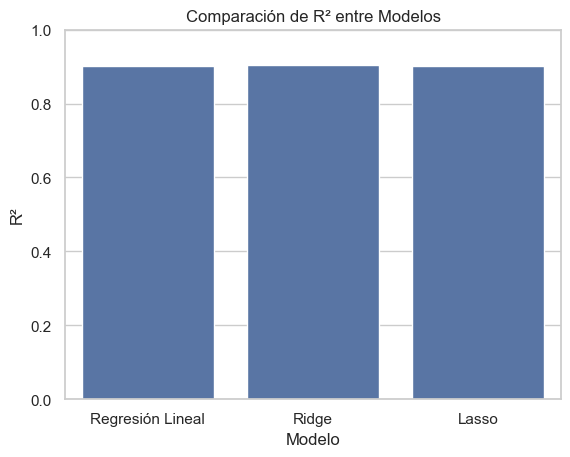


El mejor modelo es: Ridge

Explicación:

1. Regresión Lineal: Modelo básico sin regularización. Puede sufrir de sobreajuste con muchas variables.
2. Ridge: Introduce regularización L2 que ayuda con multicolinealidad pero mantiene todas las variables.
3. Lasso: Introduce regularización L1 que puede eliminar variables no importantes (coeficientes cero).

El mejor modelo será aquel que tenga mayor R² y menores errores (MAE, MSE). 
En este caso, el modelo con mejor rendimiento es {best_model}, lo que sugiere que {reason}.



In [24]:
# Crear dataframe con los resultados
results = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Ridge', 'Lasso'],
    'R²': [r2_lr, r2_ridge, r2_lasso],
    'MAE': [mae_lr, mae_ridge, mae_lasso],
    'MSE': [mse_lr, mse_ridge, mse_lasso],
    'Alpha': ['N/A', best_alpha_ridge, best_alpha_lasso]
})

print("\nComparación de Modelos:")
print(results)

# Gráfico de comparación de R²
sns.barplot(x='Modelo', y='R²', data=results)
plt.title('Comparación de R² entre Modelos')
plt.ylim(0, 1)
plt.show()

# Determinar el mejor modelo
best_model = results.loc[results['R²'].idxmax(), 'Modelo']
print(f"\nEl mejor modelo es: {best_model}")

# Explicación detallada
